In [47]:
from scipy import io
import pandas as pd
import umap # First time you run this enter pip install umap-learn in your Anaconda Prompt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 
from sklearn.cluster import KMeans
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [2]:
norm = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx'
c = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx_cols'
r = 'E-GEOD-100911.aggregated_filtered_normalised_counts.mtx_rows'
cols = []
rows = []
data = io.mmread(norm)
with open(c) as file:
    for line in file:
        cols.append(line.rstrip())

# with open(r) as file:
#     for line in file:
#         rows.append(line.rstrip().split('\t')[0])
# arr = data.toarray()

In [4]:
# norm_counts = pd.DataFrame(arr, index = rows, columns = cols)
# norm_counts.info()

In [5]:
# This was run to convert the gene transcript IDs to KEGG IDs, since this process took so long
# the result was saved to a csv (geneID.csv) file and this code is not needed anymore. 

# from Bio import Entrez
# import time
# import csv

# Entrez.email = "mdpouls1@gmail.com"
# geneIDs = []
# rowsTest = rows[15000:]
# i = 0
# while i < len(rowsTest):
#     for t in range(3):
#         if i < len(rowsTest):
#             handle = Entrez.esearch(db="gene", term=rowsTest[i])
#             record = Entrez.read(handle)
#             if len(record['IdList']) == 1:
#                 geneIDs.append(record['IdList'][0])
#             elif len(record['IdList']) > 1:
#                 geneIDs.append('multiple')
#             else:
#                 geneIDs.append('NaN')
#             handle.close()
#             i += 1
#     time.sleep(1)

# with open('geneID.csv', 'a') as f:
#     for gene in geneIDs:
#         f.write('{},'.format(gene))


In [6]:
ID_Data = pd.read_csv('geneID.csv')
IDs = ID_Data.columns

In [7]:
# norm_counts['geneIDs'] = IDs
# norm_counts.head(10)

In [8]:
# with open('dataFile.txt', 'w') as file:
#     file.write(' '.join(norm_counts['geneIDs'].to_list()))

In [9]:
annotationData = pd.read_table('uniprotData.tab')

In [10]:
annotationData = annotationData.rename(columns={"yourlist:M20210331A94466D2655679D1FD8953E075198DA81B3BDFU": "Ids"})

In [11]:
annotationData = annotationData.drop("yourlist:M20210331A94466D2655679D1FD8953E075198DA81B3B2BO", axis=1)

In [12]:
annotationData.head()


,Ids,Entry,Entry name,Status,Protein names,Gene names,Organism,Length,Pathway,Function [CC],Tissue specificity,Developmental stage,Gene ontology (biological process),Gene ontology IDs,Cross-reference (KEGG),Annotation,Keywords
0,368418,Q90X48,S35A5_DANRE,reviewed,Probable UDP-sugar transporter protein SLC35A5...,slc35a5 si:bZ20I5.1 zgc:66231,Danio rerio (Zebrafish) (Brachydanio rerio),440,NaN,NaN,NaN,NaN,carbohydrate transport [GO:0008643],GO:0005794; GO:0008643; GO:0015165; GO:0030173,dre:368418;,2 out of 5,Glycoprotein;Membrane;Reference proteome;Sugar...
1,64604,Q90X44,NRF1_DANRE,reviewed,Nuclear respiratory factor 1 (Nrf-1) (Not real...,nrf1,Danio rerio (Zebrafish) (Brachydanio rerio),514,NaN,FUNCTION: Probable transcription factor that i...,NaN,DEVELOPMENTAL STAGE: Expressed in the developi...,cellular response to cold [GO:0070417]; multic...,GO:0000978; GO:0001046; GO:0001895; GO:0003407...,dre:64604;,5 out of 5,Activator;Alternative splicing;DNA-binding;Dev...
2,368425,Q7ZUF3,Q7ZUF3_DANRE,unreviewed,Ube2h protein (Ubiquitin-conjugating enzyme E2...,ube2h,Danio rerio (Zebrafish) (Brachydanio rerio),183,NaN,NaN,NaN,NaN,protein polyubiquitination [GO:0000209]; ubiqu...,GO:0000209; GO:0005524; GO:0005634; GO:0006511...,dre:368425;,2 out of 5,ATP-binding;Nucleotide-binding;Proteomics iden...
3,327272,Q6P2U7,Q6P2U7_DANRE,unreviewed,Na(+)/H(+) exchange regulatory cofactor NHE-RF,slc9a3r1a slc9a3r1 slc9a3r2,Danio rerio (Zebrafish) (Brachydanio rerio),384,NaN,FUNCTION: Scaffold protein that connects plasm...,NaN,NaN,otic vesicle development [GO:0071599]; protein...,GO:0001726; GO:0005102; GO:0005902; GO:0006612...,dre:327272;,4 out of 5,Cell projection;Membrane;Proteomics identifica...
4,327272,Q7ZVX1,Q7ZVX1_DANRE,unreviewed,Na(+)/H(+) exchange regulatory cofactor NHE-RF,slc9a3r1a slc9a3r1 slc9a3r2,Danio rerio (Zebrafish) (Brachydanio rerio),386,NaN,FUNCTION: Scaffold protein that connects plasm...,NaN,NaN,otic vesicle development [GO:0071599]; protein...,GO:0001726; GO:0005102; GO:0005902; GO:0006612...,dre:327272;,4 out of 5,Cell projection;Membrane


In [13]:
import pandas as pd
norm_counts = pd.read_csv('norm_counts_data.csv')


In [14]:
norm_counts = norm_counts.set_index('Unnamed: 0')
norm_transpose = norm_counts.transpose()
norm_transpose.head()

Unnamed: 0,ENSDARG00000000001,ENSDARG00000000018,ENSDARG00000000019,ENSDARG00000000068,ENSDARG00000000069,ENSDARG00000000086,ENSDARG00000000103,ENSDARG00000000142,ENSDARG00000000151,ENSDARG00000000183,...,ENSDARG00000117145,ENSDARG00000117155,ENSDARG00000117156,ENSDARG00000117159,ENSDARG00000117163,ENSDARG00000117174,ENSDARG00000117179,ENSDARG00000117185,ENSDARG00000117193,ENSDARG00000117200
SRR5810686,0,0,0,0,108.114,0,0,0,0,0,...,0,0,0,0,0,12.317,0,0,0,43.3145
SRR5810687,0,0,0,0,477.412,0,0,0,23.7626,0,...,0,0,0,0,0,42.1412,0,0,0,0
SRR5810688,0,0,0,0,0,21.6638,0,0,0,0,...,0,0,0,0,0,15.2411,0,0,0.929224,75.6355
SRR5810689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.42728e-07,0,0,0,0
SRR5810690,3.02173,0,0,0,342.167,0,0,0,0,0,...,0,0,11.311,0,6.81204,9.55599,0,0,0,35.2535


In [15]:
norm_transpose_dropped = norm_transpose.drop('geneIDs')
norm_transpose_dropped


Unnamed: 0,ENSDARG00000000001,ENSDARG00000000018,ENSDARG00000000019,ENSDARG00000000068,ENSDARG00000000069,ENSDARG00000000086,ENSDARG00000000103,ENSDARG00000000142,ENSDARG00000000151,ENSDARG00000000183,...,ENSDARG00000117145,ENSDARG00000117155,ENSDARG00000117156,ENSDARG00000117159,ENSDARG00000117163,ENSDARG00000117174,ENSDARG00000117179,ENSDARG00000117185,ENSDARG00000117193,ENSDARG00000117200
SRR5810686,0,0,0,0,108.114,0,0,0,0,0,...,0,0,0,0,0,12.317,0,0,0,43.3145
SRR5810687,0,0,0,0,477.412,0,0,0,23.7626,0,...,0,0,0,0,0,42.1412,0,0,0,0
SRR5810688,0,0,0,0,0,21.6638,0,0,0,0,...,0,0,0,0,0,15.2411,0,0,0.929224,75.6355
SRR5810689,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,3.42728e-07,0,0,0,0
SRR5810690,3.02173,0,0,0,342.167,0,0,0,0,0,...,0,0,11.311,0,6.81204,9.55599,0,0,0,35.2535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR5810927,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR5810928,3123.14,0,211.692,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
SRR5810929,0,0,0,0,0,0,164.376,0,0,0,...,0,0,0,0,0,1.29792e-05,0,0,0,0
SRR5810930,0,0,168.699,0.860707,0,0,0,0,82.6278,0,...,0.860707,0,0,0,0,11.907,0,0,0,0


In [16]:
#geneID_dict['64604']

In [17]:
# # #comvert the gene ontology codes to dummy columns in a dataframe for each gene ID then saved as a csv. 

# GO = []
# go_dict = {}
# for line in annotationData['Gene ontology (biological process)'].str.split(';'):
#     if type(line) == list:
#         for item in line:
#             GO.append(item.strip())

# for term in GO:
#     if term not in go_dict:
#         go_dict[term] = []

# for line in annotationData['Gene ontology (biological process)'].str.split(';'):
#     item_dict = {}
#     if type(line) == list:
#         for item in line:
#             item_dict[item.strip()] = True
#         for k,v in go_dict.items():
#             if k in item_dict:
#                 v.append(1)
#             else:
#                 v.append(0)

        
# go_df = pd.DataFrame.from_dict(go_dict)
# go_df['geneId'] = annotationData['Ids']

# go_df = go_df.set_index('geneId')
# go_df.head()

# go_df.to_csv('goData.csv')
    

In [18]:
# for k,v in go_dict.items():
#     print(k)

In [19]:
# norm_counts.head()

In [20]:
# norm_counts_id = norm_counts.set_index("geneIDs")
# new = norm_counts.merge(go_df,left_on='geneIDs', right_on='geneId')
# new.head()

In [21]:
# new = new.set_index('geneIDs')
# new.head()

In [22]:
# srr_dict = norm_counts_id.to_dict()

In [23]:
# srr_dict['SRR5810686']

In [24]:
# gene_dict = go_df.to_dict('split')

In [25]:
# geneID_dict = {}
# for ind, data in gene_dict.items():
#     geneID_dict[ind] = data

In [26]:
# srr_dict = norm_counts_id.to_dict()
# gene_dict = go_df.to_dict('split')    

In [27]:
# geneID_dict = {}
# for ind, data in gene_dict.items():
#     geneID_dict[ind] = data


In [28]:
# ids = gene_dict['index']
# data = gene_dict['data']

# geneID_dict = {}
# for i in range(len(ids)):
#     geneID_dict[ids[i]] = data[i]

In [29]:
# srr_genes_dict_values = {}
# for srr,genes in srr_dict.items():
#     genes_GO = np.zeros((5075,), dtype=int)
#     for gene,value in genes.items():
#         if value > 0:
#             if gene in geneID_dict:
#                 genes_GO = np.add(genes_GO,np.multiply(value, np.array(geneID_dict[gene])))
#     srr_genes_dict_values[srr] = genes_GO


In [30]:
# cols = go_df.columns

In [31]:
#gene_annotation_values_df = pd.DataFrame.from_dict(srr_genes_dict_values, orient='index', columns = cols)

In [32]:
# gene_annotation_values_df.head()norm_counts['geneIDs'] = IDs
# norm_counts.head(10)

In [33]:
# norm_counts.to_csv('norm_counts_data.csv')

In [34]:
# with open('dataFile.txt', 'w') as file:
#     file.write(' '.join(norm_counts['geneIDs'].to_list()))

In [35]:
#annotationData = pd.read_table('uniprotData.tab')

In [36]:
#gene_annotation_values_df.to_csv('GeneAnnotation.csv')

In [37]:
#annotationData = annotationData.drop("yourlist:M20210331A94466D2655679D1FD8953E075198DA81B3B2BO", axis=1)

In [38]:
#annotationData.head()

# UMAP Reduction:

See the UMAP Documentation page for details. The module import cell at the top of this notebook has instructions for downloading the scikit learn plug-in for UMAP.

NOTE This is a first pass - I'm not super sure it is ready to go. Next steps

1 We need to cluster the data and assign tags to the data points

2 Add a third dimension to the UMAP reduction

3 Plot data in altair to allow interaction

4 Add interaction steps, tags, whatever else we're doing!


In [39]:
norm_counts_temp = norm_counts
norm_counts_temp = norm_counts_temp.drop(['geneIDs'],axis=1).transpose()
norm_vals = norm_counts_temp.values

In [40]:
norm_vals_scaled = StandardScaler().fit_transform(norm_vals)

In [41]:
UMAP_reducer = umap.UMAP()
reduced_genes = UMAP_reducer.fit_transform(norm_vals_scaled)
print('Done')

Done


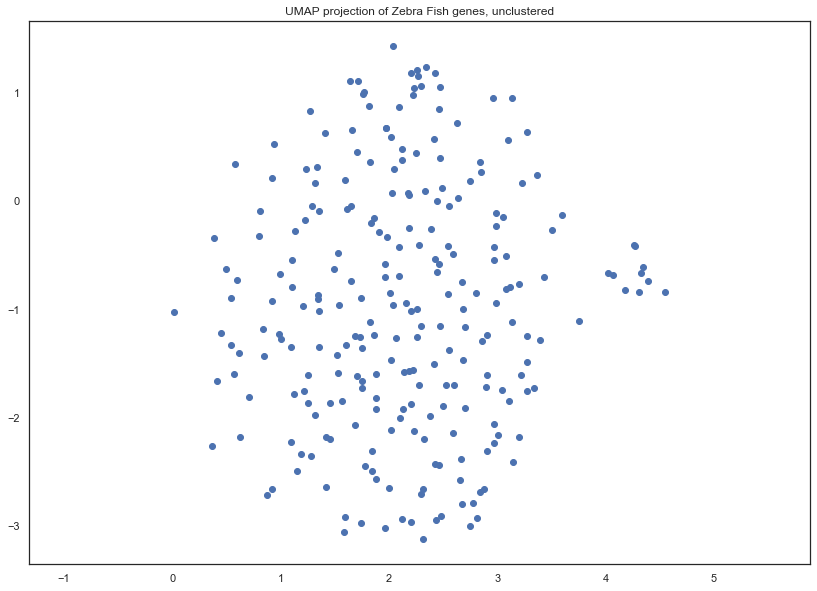

In [42]:
plt.scatter(reduced_genes[:,0],reduced_genes[:,1])
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')
plt.show;

In [43]:
X = norm_vals_scaled
# PCA
pca_mod = PCA(n_components = 7)
data_pca = pca_mod.fit_transform(X)
PCs =pca_mod.components_
PCs.shape

(7, 17432)

In [44]:
UMAP_mod = umap.UMAP(n_neighbors = 7, min_dist = 0.2, n_components = 3).fit_transform(X)

In [45]:
# K means
y_pred = KMeans(n_clusters=7, max_iter=5).fit_predict(X)

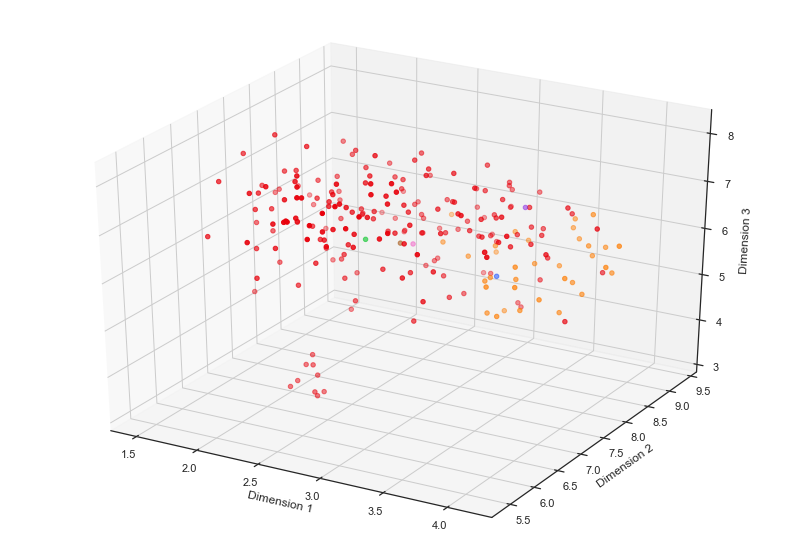

In [48]:
# colors
from matplotlib.colors import ListedColormap
colors = ListedColormap(sns.color_palette('bright', 7).as_hex())
# plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(UMAP_mod[:, 0], UMAP_mod[:, 1],zs= UMAP_mod[:, 2], c=y_pred, cmap= colors, s=20)
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
ax.set_zlabel('Dimension 3')
plt.show()

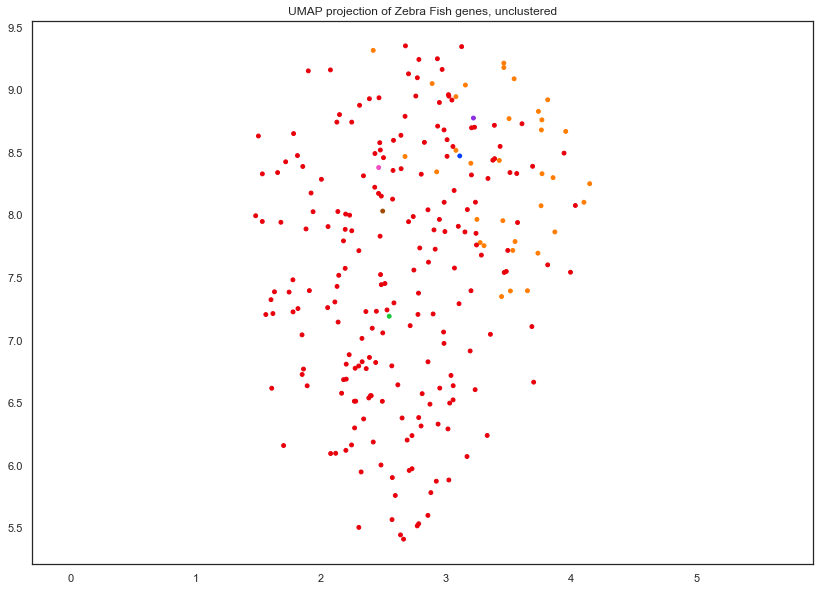

In [49]:
plt.scatter(UMAP_mod[:,0],UMAP_mod[:,1], c = y_pred, cmap = colors, s=15)
plt.gca().set_aspect('equal','datalim')
plt.title('UMAP projection of Zebra Fish genes, unclustered')
plt.show;

## Get top gene ontologies:  


In [58]:
annotation = pd.read_csv('GeneAnnotation.csv')
annot_vals = annotation.values

annot_scaled = StandardScaler().fit_transform(annot_vals)


# PCA
pca_mod = PCA(n_components = 1)
data_pca = pca_mod.fit_transform(annot_scaled)
PCs =pca_mod.components_

In [73]:
PCs_df = pd.DataFrame(PCs)
PCs_df = an.transpose()
PCs_df[1] = abs(PCs_df[0])
topGo = PCs_df[1].sort_values(ascending = False).head(100).index

In [74]:
topGo

Int64Index([ 315,  962, 2527, 2918, 2526, 2525,  697, 2746, 1298, 1949, 2784,
            2652,  722,  329, 3718, 2406, 3067,  362, 2958, 4208,  516, 2424,
            4019, 4504, 4503, 4070, 3347, 2367, 3641, 1334, 2528, 1885, 3215,
            2114,   81, 2518, 3068, 3214, 2549,   86, 2272,  312, 3238, 3348,
            1445,  381,   43,  208, 1852, 2185, 2184, 2188, 2189, 2187, 2833,
            2098,  313, 1213, 1262,  290, 4054, 1058, 3256,  842,  525,  153,
            2010, 1943, 1123,   46, 1092,   54, 2183,  792,  522,  798, 3766,
            3763, 3767, 3764, 3765, 1478, 3105,  234,  894,  789,  247, 1068,
            2574, 2575, 1517,  778, 1157,  631,  365,  806, 3084, 2431,  335,
               0],
           dtype='int64')

## Visualization:
**Overview**
 - The 'base' plot is the 2-D UMAP plot plotted using Altair. 
 - A user can then select a region-of-interest to create the breakout histogram plots of predominate gene ontology

In [ ]:
import altair as alt

### Create visualization dataframe:  
**Overview** by creating a dataframe with the reduced dimension data and add in additional properties as necessary (i.e. cluster number, ontology, etc.)  
  
**To-do:**  
 - Add cluster IDs
 - Add gene ontologies
 - Add primary genes?

In [ ]:
# Create 'base' dataframe:
column_names = ["UMAP x","UMAP y"]
vis_data = pd.DataFrame(reduced_genes, columns = column_names)

# Add clusters:
vis_data["Clusters"] = y_pred

vis_data.head()

### Create 'master' plot  
**TODO** 
 - Add cluster colors
 - Add IDs when hovering?
 - Add ROI selection

In [ ]:
ROI = alt.selection_interval()

scatter = alt.Chart(vis_data).mark_point().encode(
    alt.X('UMAP x',
          scale=alt.Scale(zero=False)
         ),
    alt.Y('UMAP y',
          scale=alt.Scale(zero=False)
         ),
    color = 'Clusters'
    ).add_selection(ROI)

# Show chart for development purpose:
scatter


### Create histogram plot of ontologies:
**Thoughts:**
 - Altair does seem to be one of the easier plotting systems to select data
 - Altair does not output the indicies of the ROI without an API that may be out there...
 - I can 'transform' the data using:
  - Density Transform | create a vector of all of the ontologies, show a density plot of these ontologies
  - 

In [ ]:
# Create the base chart:
hist_base = alt.Chart(vis_data).mark_bar().encode(
    x = 'count()',
    y = 'Clusters',
    color = 'Clusters'
).properties(
    width = 500,
    height = 200
).transform_filter(
    ROI
)

# Filter by interaction:
# hist = hist_base.encode()


# Display for dev purposes:
scatter | hist_base

### Display tool!
**This is where our interaction is!**

In [ ]:
scatter & hist

## Main Dataset

In [ ]:
# unpublished data from cell ranger pipeline
# testis1
t1data = io.mmread('15756X3/matrix.mtx.gz')
t1arr = t1data.toarray()
t1col = pd.read_csv('15756X3/barcodes.tsv.gz', compression = 'gzip', header=None, sep = '\t')
t1row = pd.read_csv('15756X3/features.tsv.gz', compression = 'gzip', header=None,sep = '\t')
t1row = t1row[[1]]

In [ ]:
t1_counts = pd.DataFrame(t1arr, index = t1row, columns = t1col)
t1_counts.info()